Se debe descargar el dataset del enlace https://www.kaggle.com/datasets/prepinstaprime/black-friday-sales-data

# Exploración y limpieza

In [1]:
import pandas

sales_df = pandas.read_csv("./train.csv")

In [2]:
sales_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
print("Dimensiones del dataset:\n")
print(sales_df.shape)
print("\nTipos de las columnas y cantidad de valores únicos:\n")

column_types = sales_df.dtypes
uniques = sales_df.nunique()

column_summary = pandas.concat([column_types, uniques], axis=1, keys=["dtype", "uniques"])

print(column_summary)

Dimensiones del dataset:

(550068, 12)

Tipos de las columnas y cantidad de valores únicos:

                              dtype  uniques
User_ID                       int64     5891
Product_ID                   object     3631
Gender                       object        2
Age                          object        7
Occupation                    int64       21
City_Category                object        3
Stay_In_Current_City_Years   object        5
Marital_Status                int64        2
Product_Category_1            int64       20
Product_Category_2          float64       17
Product_Category_3          float64       15
Purchase                      int64    18105


Observamos que el dataset no presenta columna de tipo identificador único, que las columnas `Gender`, `Age`, `City_Category` y `Stay_In_Current_City_Years` son categóricas de tipo objecto (string) y que `Occupation` y `Marital_Status` son categóricas codificadas como entero.


Conteo absoluto y porcentual de valores nulos por columna.

In [4]:
nan_counts = sales_df.isnull().sum()
nan_pct = round(nan_counts / len(sales_df), 2)

nan_summary = pandas.concat([nan_counts, nan_pct], axis=1, keys=["count", "pct"])

print(nan_summary)

                             count   pct
User_ID                          0  0.00
Product_ID                       0  0.00
Gender                           0  0.00
Age                              0  0.00
Occupation                       0  0.00
City_Category                    0  0.00
Stay_In_Current_City_Years       0  0.00
Marital_Status                   0  0.00
Product_Category_1               0  0.00
Product_Category_2          173638  0.32
Product_Category_3          383247  0.70
Purchase                         0  0.00


Sólo las columnas `Product_Category_2` y `Product_Category_3` tienen valores nulos, 173.638 y 383.247, lo que representa un 32% y un 70% de valores nulos sobre el total de los datos, respectivamente.

In [5]:
sales_df.duplicated().sum()

0

El dataset no presenta columnas duplicadas.

In [6]:
print("Valores únicos de las columnas Product_Category 1, 2 y 3:\n")

print("Product_Category_1")
print(sorted(sales_df['Product_Category_1'].unique()))

print("Product_Category_2")
print(sorted(sales_df['Product_Category_2'].unique()))

print("Product_Category_3")
print(sorted(sales_df['Product_Category_3'].unique()))


Valores únicos de las columnas Product_Category 1, 2 y 3:

Product_Category_1
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Product_Category_2
[nan, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]
Product_Category_3
[nan, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0]


Como vimos antes, ProdCat1 es de tipo entero y no tiene valores nulos, mientras que ProdCat2 y ProdCat3 son de tipo flotante y sí tiene valores nulos. 

los valores de ProdCat1 van del 1 al 20;
los de ProdCat 2, del 2 al 18;
los de ProdCat 3, del 3 al 18 (saltándose el 7).

In [7]:
condition_a = sales_df['Product_Category_2'].isnull() & sales_df['Product_Category_3'].notnull()
all_nulls_in_2_are_null_in_3 = not condition_a.any()

condition_b = sales_df['Product_Category_3'].isnull() & sales_df['Product_Category_2'].notnull()
all_nulls_in_3_are_null_in_2 = not condition_b.any()

print("¿Todos los nulos en Product_Category_2 son también nulos en Product_Category_3?")
print(all_nulls_in_2_are_null_in_3)

print("¿Todos los nulos en Product_Category_3 son también nulos en Product_Category_2?")
print(all_nulls_in_3_are_null_in_2)

¿Todos los nulos en Product_Category_2 son también nulos en Product_Category_3?
True
¿Todos los nulos en Product_Category_3 son también nulos en Product_Category_2?
False


In [8]:
# Tabla cruzada de valores nulos
crosstab = pandas.crosstab(sales_df['Product_Category_2'].isnull(), sales_df['Product_Category_3'].isnull(), rownames=['2 is null'], colnames=['3 is null'])
print(crosstab)

3 is null   False   True 
2 is null                
False      166821  209609
True            0  173638


In [9]:
null_pc2 = sales_df['Product_Category_2'].isnull().astype(int)
null_pc3 = sales_df['Product_Category_3'].isnull().astype(int)

# Calcular la correlación
correlation = null_pc2.corr(null_pc3)
print(f"Correlación entre los nulos de ProdCat2 y ProdCat3: {round(correlation, 2)}")

Correlación entre los nulos de ProdCat2 y ProdCat3: 0.45


# Preprocesamiento

Creamos una copia del DataFrame para realizar el preprocesamiento sobre éste sin modificar al objeto original.

In [10]:
cleaned_sales = sales_df.copy()

Codificamos las varibales categóricas en valores numéricos.

In [11]:
def generate_map(unique_values):
    return {value: idx for idx, value in enumerate(unique_values)}

In [12]:
gender_uniques = sales_df['Gender'].unique()
age_uniques = sorted(sales_df['Age'].unique())
city_uniques = sorted(sales_df['City_Category'].unique())
stay_in_city_uniques = sorted(sales_df['Stay_In_Current_City_Years'].unique())

gender_map = generate_map(gender_uniques)
age_map = generate_map(age_uniques)
city_map = generate_map(city_uniques)
stay_in_city_map = generate_map(stay_in_city_uniques)

print(gender_map)
print(age_map)
print(city_map)
print(stay_in_city_map)

{'F': 0, 'M': 1}
{'0-17': 0, '18-25': 1, '26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}
{'A': 0, 'B': 1, 'C': 2}
{'0': 0, '1': 1, '2': 2, '3': 3, '4+': 4}


In [13]:
cleaned_sales['Gender'] = sales_df['Gender'].map(gender_map)
cleaned_sales['Age'] = sales_df['Age'].map(age_map)
cleaned_sales['City_Category'] = sales_df['City_Category'].map(city_map)
cleaned_sales['Stay_In_Current_City_Years'] = sales_df['Stay_In_Current_City_Years'].map(stay_in_city_map)

Verificamos que el Product_ID de todos los registros cumpla con la forma “carácter ´P´ seguido de dígitos (0-9)”.

In [14]:
cumple_formato = sales_df['Product_ID'].str.match(r'^P\d+$').all()

print(cumple_formato) 

True


Como se cumple la condición, eliminamos la "P" y convertimos el valor a entero.

In [15]:
cleaned_sales['Product_ID'] = sales_df['Product_ID'].str[1:].astype('int64')

In [16]:
cleaned_sales.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,69042,0,0,10,0,2,0,3,NaN,NaN,8370
1,1000001,248942,0,0,10,0,2,0,1,6.0,14.0,15200
2,1000001,87842,0,0,10,0,2,0,12,NaN,NaN,1422
3,1000001,85442,0,0,10,0,2,0,12,14.0,NaN,1057
4,1000002,285442,1,6,16,2,4,0,8,NaN,NaN,7969


Analizamos los valores de las columnas `Product_Category_2` y `Product_Category_3` para realizar tratamiento de valores faltantes.

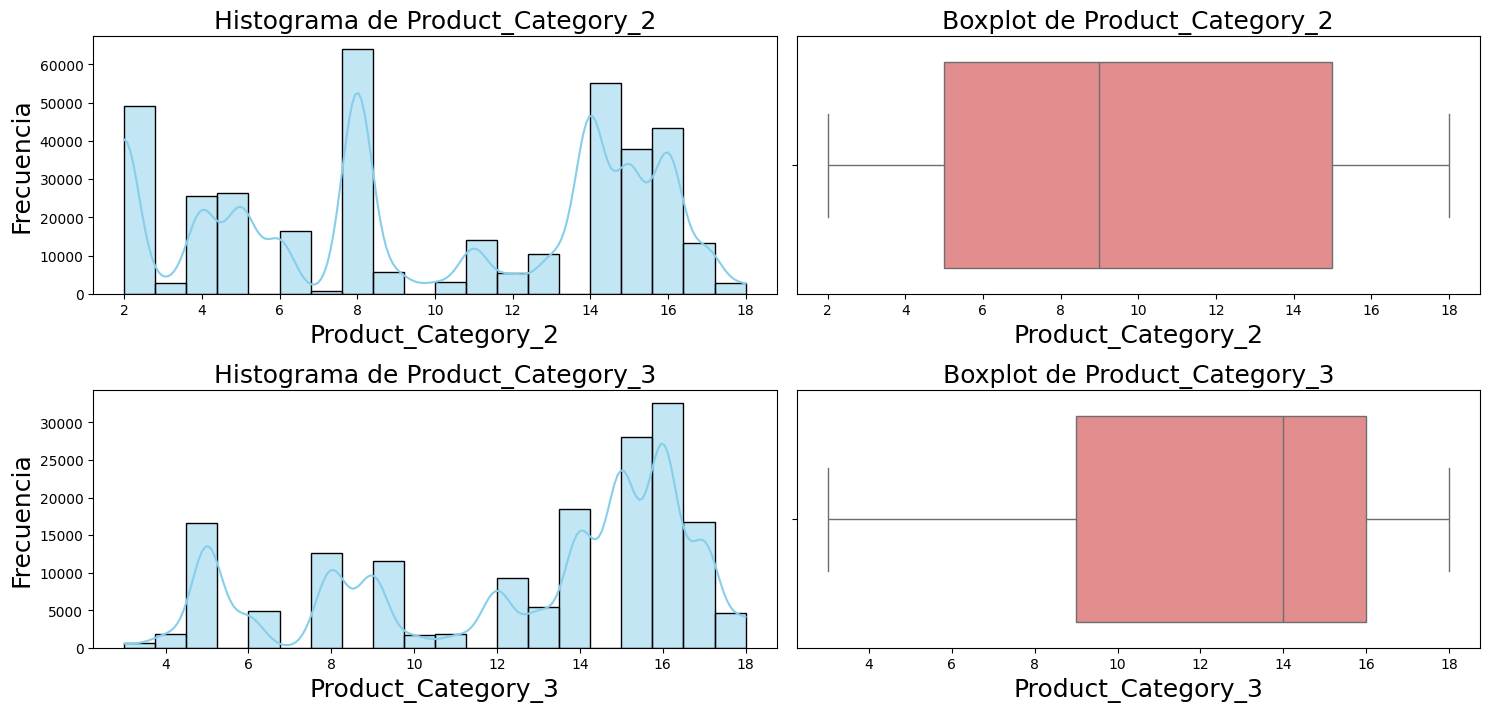

In [17]:
from matplotlib import pyplot
import seaborn

columns_with_missing_values = ['Product_Category_2', 'Product_Category_3']

pyplot.figure(figsize=(15, 35))

for i, variable in enumerate(columns_with_missing_values, 1):
    pyplot.subplot(10, 2, i*2-1)
    seaborn.histplot(sales_df[variable], bins=20, kde=True, color='skyblue')
    pyplot.title(f'Histograma de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)
    pyplot.ylabel('Frecuencia', fontsize=18)

    pyplot.subplot(10, 2, i*2)
    seaborn.boxplot(x=sales_df[variable], color='lightcoral')
    pyplot.title(f'Boxplot de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)

pyplot.subplots_adjust(hspace=0.6)

pyplot.tight_layout()
pyplot.show()


Dado que las columnas no tienen una distribución normal, se procede a imputar los valores nulos respecto a la mediana.

In [19]:
from sklearn.impute import SimpleImputer
import numpy

imp_mean = SimpleImputer(missing_values=numpy.nan, strategy='median')

cleaned_sales[columns_with_missing_values] = imp_mean.fit_transform(sales_df[columns_with_missing_values]).astype('int64')

print(cleaned_sales[columns_with_missing_values].head())

   Product_Category_2  Product_Category_3
0                   9                  14
1                   6                  14
2                   9                  14
3                  14                  14
4                   9                  14


Categorización ordinal de la variable objetivo `Purchase`.

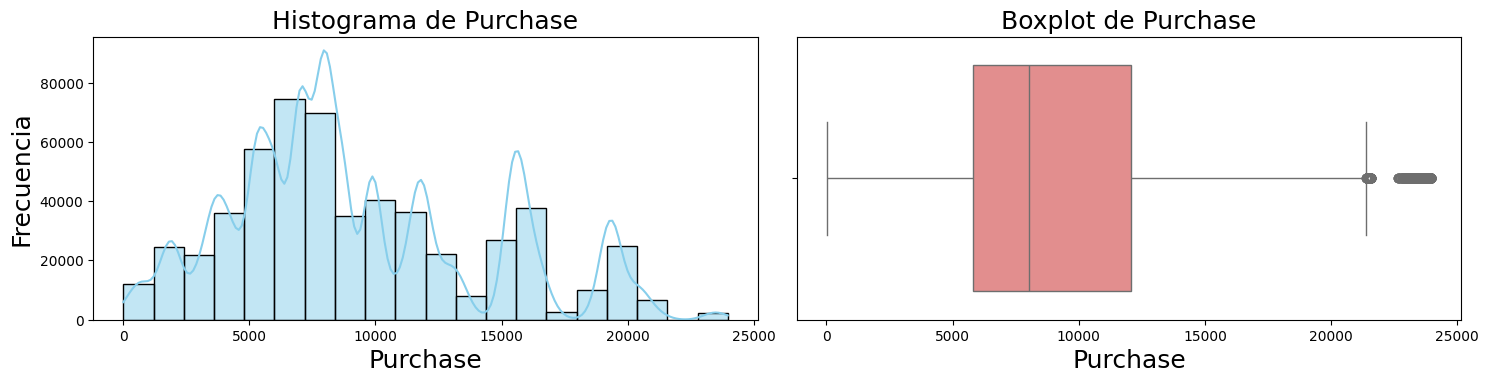

In [20]:
from matplotlib import pyplot
import seaborn

pyplot.figure(figsize=(15, 35))

for i, variable in enumerate(['Purchase'], 1):
    pyplot.subplot(10, 2, i*2-1)
    seaborn.histplot(sales_df[variable], bins=20, kde=True, color='skyblue')
    pyplot.title(f'Histograma de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)
    pyplot.ylabel('Frecuencia', fontsize=18)

    pyplot.subplot(10, 2, i*2)
    seaborn.boxplot(x=sales_df[variable], color='lightcoral')
    pyplot.title(f'Boxplot de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)

pyplot.subplots_adjust(hspace=0.6)

pyplot.tight_layout()
pyplot.show()

In [21]:
min_valor = sales_df['Purchase'].min()
max_valor = sales_df['Purchase'].max()
media = sales_df['Purchase'].mean()  
mediana = sales_df['Purchase'].median() 

print(f"Mínimo: {min_valor}")
print(f"Máximo: {max_valor}")
print(f"Media: {media}")
print(f"Mediana: {mediana}")

Mínimo: 12
Máximo: 23961
Media: 9263.968712959126
Mediana: 8047.0


Definimos los grupos de categorización en base a los cuartiles de la columna.

In [22]:
percentiles = sales_df["Purchase"].quantile([0.25, 0.5, 0.75])

print(percentiles)

cleaned_sales["Purchase"] = pandas.cut(
    sales_df["Purchase"],
    bins=[
        0,
        percentiles[0.25],
        percentiles[0.5],
        percentiles[0.75],
        sales_df["Purchase"].max(),
    ],
    labels=["bajo", "medio-bajo", "medio-alto", "alto"],
)
cleaned_sales["Purchase"] = cleaned_sales["Purchase"].cat.codes.astype("int64")

0.25     5823.0
0.50     8047.0
0.75    12054.0
Name: Purchase, dtype: float64


In [23]:
column_types = cleaned_sales.dtypes
uniques = cleaned_sales.nunique()

column_summary = pandas.concat([column_types, uniques], axis=1, keys=["dtype", "uniques"])

print(column_summary)

                            dtype  uniques
User_ID                     int64     5891
Product_ID                  int64     3631
Gender                      int64        2
Age                         int64        7
Occupation                  int64       21
City_Category               int64        3
Stay_In_Current_City_Years  int64        5
Marital_Status              int64        2
Product_Category_1          int64       20
Product_Category_2          int64       17
Product_Category_3          int64       15
Purchase                    int64        4


Con el DataFrame ya procesado a una matriz de valores enteros, procedemos a almacenarlo en el directorio de trabajo para luego utilizarlo para entrenar modelos.

In [24]:
# Guardar el DataFrame limpio como binario en el directorio
cleaned_sales.to_pickle("cleaned_sales.pkl")

# Entrenamiento de modelos

In [25]:
sales_train_data = pandas.read_pickle("cleaned_sales.pkl")

## División del dataset

In [ ]:
y = sales_train_data.Purchase
X = sales_train_data.drop('Purchase',axis = 1)

In [27]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_normalized = normalizer.fit_transform(X)

In [28]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# División de temp en validation (50%) y test (50%), es decir, 10% cada uno del total
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

# Verificar tamaños
print(f'Train: {len(X_train)}')
print(f'Train: {len(y_train)}')
print(f'Validation: {len(X_val)}')
print(f'Validation: {len(y_val)}')
print(f'Test: {len(X_test)}')
print(f'Test: {len(y_test)}')

Train: 440054
Train: 440054
Validation: 55007
Validation: 55007
Test: 55007
Test: 55007


## Red Neuronal Multicapa (MLP) con PyTorch

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Convertir datos de NumPy a Tensores

In [ ]:
# Convertir datos a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Para clasificación

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

Crear DataLoader para manejar los datos

In [ ]:
batch_size = 32  # How many samples per batch to load (default: 1).

# Crear conjuntos de datos
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Definir la arquitectura del MLP

In [88]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Parámetros de la red
input_size = X_train.shape[1]       # Número de características de entrada = 11 columnas 
hidden_size = 64                    # Número de neuronas en las capas ocultas
output_size = len(y_train.unique()) # Número de clases = 4 valores únicos de Purchase
dropout_prob = 0.3

# Inicializar modelo
model = MLP(input_size, hidden_size, output_size, dropout_prob)

Configurar función de pérdida y optimizador

In [84]:
criterion = nn.CrossEntropyLoss()  # Para clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.001)

Entrenar el modelo

In [89]:
num_epochs = 30  # Ajustable

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Resetear gradientes
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Calcular pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar pesos
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/30], Loss: 1.3884
Epoch [2/30], Loss: 1.3884
Epoch [3/30], Loss: 1.3885
Epoch [4/30], Loss: 1.3885
Epoch [5/30], Loss: 1.3884
Epoch [6/30], Loss: 1.3884
Epoch [7/30], Loss: 1.3885
Epoch [8/30], Loss: 1.3884
Epoch [9/30], Loss: 1.3884
Epoch [10/30], Loss: 1.3883
Epoch [11/30], Loss: 1.3885
Epoch [12/30], Loss: 1.3884
Epoch [13/30], Loss: 1.3885
Epoch [14/30], Loss: 1.3884
Epoch [15/30], Loss: 1.3884
Epoch [16/30], Loss: 1.3885
Epoch [17/30], Loss: 1.3884
Epoch [18/30], Loss: 1.3884
Epoch [19/30], Loss: 1.3885
Epoch [20/30], Loss: 1.3885
Epoch [21/30], Loss: 1.3884
Epoch [22/30], Loss: 1.3885
Epoch [23/30], Loss: 1.3883
Epoch [24/30], Loss: 1.3885
Epoch [25/30], Loss: 1.3885
Epoch [26/30], Loss: 1.3884
Epoch [27/30], Loss: 1.3885
Epoch [28/30], Loss: 1.3885
Epoch [29/30], Loss: 1.3883
Epoch [30/30], Loss: 1.3885


Evaluar el modelo

In [90]:
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

train_acc = evaluate_model(model, train_loader)
val_acc = evaluate_model(model, val_loader)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Train Accuracy: 0.2499
Validation Accuracy: 0.2499


Prueba final con el conjunto de test

In [91]:
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.2499


## 2do Modelo

In [41]:
import torch.nn as nn

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# Definir el tamaño de entrada, salida y capa oculta
input_size = X_train.shape[1]  # Número de características
hidden_size = 128  # Tamaño arbitrario de la capa oculta
output_size = len(y.unique())  # Número de clases (valores únicos de y)

# Crear el modelo
model = MLPModel(input_size, hidden_size, output_size)

In [42]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Limpiar los gradientes
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()  # Retropropagación
        optimizer.step()  # Optimización
        
        running_loss += loss.item()
    
    # Calcular la pérdida promedio por época
    epoch_loss = running_loss / len(train_loader)
    
    # Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

Epoch [1/10], Train Loss: 1.3863, Val Loss: 1.3863, Val Accuracy: 24.99%
Epoch [2/10], Train Loss: 1.3863, Val Loss: 1.3863, Val Accuracy: 24.99%
Epoch [3/10], Train Loss: 1.3863, Val Loss: 1.3863, Val Accuracy: 24.99%
Epoch [4/10], Train Loss: 1.3863, Val Loss: 1.3863, Val Accuracy: 24.99%
Epoch [5/10], Train Loss: 1.3863, Val Loss: 1.3863, Val Accuracy: 24.99%
Epoch [6/10], Train Loss: 1.3863, Val Loss: 1.3863, Val Accuracy: 24.99%
Epoch [7/10], Train Loss: 1.3863, Val Loss: 1.3863, Val Accuracy: 24.99%
Epoch [8/10], Train Loss: 1.3863, Val Loss: 1.3863, Val Accuracy: 24.99%
Epoch [9/10], Train Loss: 1.3863, Val Loss: 1.3863, Val Accuracy: 24.99%
Epoch [10/10], Train Loss: 1.3863, Val Loss: 1.3863, Val Accuracy: 24.99%


In [43]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 1.3863, Test Accuracy: 24.99%


## 3er modelo

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [45]:


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # Dropout con probabilidad de 0.5
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Parámetros de la red
input_size = X_train.shape[1]  # Número de características
hidden_size = 64  # Ajustable
output_size = len(y_train.unique())  # Número de clases

# Inicializar modelo
model = MLP(input_size, hidden_size, output_size)


In [46]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [50]:
num_epochs = 30  # Ajustable

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Resetear gradientes
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Calcular pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar pesos
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/30], Loss: 1.3827
Epoch [2/30], Loss: 1.3805
Epoch [3/30], Loss: 1.3795
Epoch [4/30], Loss: 1.3792
Epoch [5/30], Loss: 1.3785
Epoch [6/30], Loss: 1.3779
Epoch [7/30], Loss: 1.3774
Epoch [8/30], Loss: 1.3773
Epoch [9/30], Loss: 1.3768
Epoch [10/30], Loss: 1.3767
Epoch [11/30], Loss: 1.3769
Epoch [12/30], Loss: 1.3777
Epoch [13/30], Loss: 1.3779
Epoch [14/30], Loss: 1.3770
Epoch [15/30], Loss: 1.3763
Epoch [16/30], Loss: 1.3762
Epoch [17/30], Loss: 1.3770
Epoch [18/30], Loss: 1.3764
Epoch [19/30], Loss: 1.3762
Epoch [20/30], Loss: 1.3760
Epoch [21/30], Loss: 1.3758
Epoch [22/30], Loss: 1.3759
Epoch [23/30], Loss: 1.3760
Epoch [24/30], Loss: 1.3759
Epoch [25/30], Loss: 1.3777
Epoch [26/30], Loss: 1.3768
Epoch [27/30], Loss: 1.3757
Epoch [28/30], Loss: 1.3758
Epoch [29/30], Loss: 1.3756
Epoch [30/30], Loss: 1.3754


In [51]:
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

train_acc = evaluate_model(model, train_loader)
val_acc = evaluate_model(model, val_loader)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Train Accuracy: 0.2838
Validation Accuracy: 0.2820


In [52]:
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.2838
